# Differential expression analysis of the clusters in the TCGA dataset

In [53]:
import glob
import pickle as pkl
import gseapy as gp
import pandas as pd
import numpy as np

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

from utils import Volcanoplot, Functional_analysis


In [54]:
# First we will charge the TCGA counts table
df_counts = pd.read_csv("./Data/DE_Functional_analysis/TCGA_counts.tsv",sep="\t").set_index("genes").T
df_counts

genes,A1BG,A1CF,A2ML1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA_2J_AAB6_01,141,14,3105,14564,1917,2,1427,994,12,103,...,778,561,939,25,460,1801,1169,20001,1486,1029
TCGA_2J_AAB8_01,60,36,18,15332,418,10,853,726,216,89,...,411,425,523,38,379,882,724,6201,881,648
TCGA_2J_AAB9_01,98,20,599,22682,1050,47,805,600,118,83,...,440,272,323,54,356,874,603,7552,1011,535
TCGA_2J_AABA_01,158,30,1395,16449,1011,10,996,1476,89,100,...,640,413,282,84,469,2414,1510,7712,2179,1267
TCGA_2J_AABE_01,128,5,121,17963,1152,57,1139,2057,268,154,...,504,321,390,92,700,1734,915,12106,1350,760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA_XN_A8T3_01,250,40,1,35666,1364,92,1407,1980,105,204,...,683,561,1035,78,501,2106,1391,11119,2391,1355
TCGA_XN_A8T5_01,206,16,20,33901,916,91,830,1659,5,142,...,553,416,326,97,674,1515,1154,11387,2228,972
TCGA_YB_A89D_01,305,144,14,45778,1676,39,1173,2204,351,144,...,586,342,451,78,849,1374,1459,17276,1837,882
TCGA_YY_A8LH_01,149,68,20,10139,694,225,1746,2361,162,144,...,879,581,979,99,911,1636,726,11569,1816,750


In [55]:
# Filter out the very low expressed genes

genes_to_keep = df_counts.columns[df_counts.sum(axis=0) >= 10]
df_counts = df_counts[genes_to_keep]
print(df_counts.shape)

# Show that there arent NaN values
print(df_counts.isna().sum().sum())

(142, 15220)
0


In [56]:
# Charge the  cluster info
df_counts.index= df_counts.index.str.replace("_","-",regex=True)

import pickle as pkl
with open("./Results/Clustering/Smple_cluster_dict.pkl", "rb") as f:
    samplesdict = pkl.load(f)

cluster = df_counts.index.map(samplesdict)

cluster

Index([0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       ...
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
      dtype='int64', length=142)

In [57]:
# Create the metadata (the cluster information) 
df_cluster= pd.DataFrame({"Sample":df_counts.index,"Condition":cluster}).set_index("Sample")
df_cluster.sort_index(inplace=True)
df_cluster

,Condition
Sample,
TCGA-2J-AAB6-01,0
TCGA-2J-AAB8-01,0
TCGA-2J-AAB9-01,1
TCGA-2J-AABA-01,0
TCGA-2J-AABE-01,0
...,...
TCGA-XN-A8T3-01,1
TCGA-XN-A8T5-01,1
TCGA-YB-A89D-01,1


In [58]:
# Initialize the DeseqDataSet object
dds = DeseqDataSet(
    counts=df_counts,
    metadata=df_cluster,
    design_factors="Condition",
    refit_cooks=True,
    
)
dds.deseq2()

Fitting size factors...
... done in 0.14 seconds.

Fitting dispersions...
... done in 10.37 seconds.

Fitting dispersion trend curve...
... done in 1.49 seconds.

Fitting MAP dispersions...
... done in 11.26 seconds.

Fitting LFCs...
... done in 5.87 seconds.

Refitting 598 outliers.

Fitting dispersions...
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 0.53 seconds.

Fitting LFCs...
... done in 0.37 seconds.



In [59]:
# Calculate the stastics , specify the contrast and perform the differential expression (DE) analysis
stat_res = DeseqStats(dds)
stat_res.contrast = ['Condition', '1','0']
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat        pvalue  \
genes                                                                     
A1BG      184.285738        0.225973  0.143631   1.573291  1.156514e-01   
A1CF       99.789130        0.187043  0.257864   0.725356  4.682339e-01   
A2ML1     633.030638       -2.279820  0.522409  -4.364056  1.276731e-05   
A2M     32760.775521        0.989025  0.088864  11.129710  8.992714e-29   
A4GALT   1355.186342       -0.463571  0.156539  -2.961385  3.062587e-03   
...              ...             ...       ...        ...           ...   
ZXDC     1984.912910       -0.126441  0.052759  -2.396554  1.655004e-02   
ZYG11B   1371.674255        0.443814  0.059245   7.491114  6.829161e-14   
ZYX     11854.274608       -0.176016  0.077876  -2.260199  2.380891e-02   
ZZEF1    2278.394087        0.467020  0.073290   6.372234  1.862949e-10   
ZZZ3     1189.573567        0.247640  0.06036

... done in 2.03 seconds.



In [60]:
# Extract and save the normalized counts from the dds object

normcounts_df = pd.DataFrame(dds.layers["normed_counts"],
                             columns=df_counts.columns,
                             index=df_counts.index).T

normcounts_df.to_csv("./Results/DE_Functional_analysis/TCGA_Deseq_normalizedcounts.csv")

normcounts_df.head()

,TCGA-2J-AAB6-01,TCGA-2J-AAB8-01,TCGA-2J-AAB9-01,TCGA-2J-AABA-01,TCGA-2J-AABE-01,TCGA-2J-AABF-01,TCGA-2J-AABK-01,TCGA-2J-AABO-01,TCGA-2J-AABR-01,TCGA-2J-AABT-01,...,TCGA-US-A77J-01,TCGA-XD-AAUG-01,TCGA-XD-AAUH-01,TCGA-XD-AAUI-01,TCGA-XD-AAUL-01,TCGA-XN-A8T3-01,TCGA-XN-A8T5-01,TCGA-YB-A89D-01,TCGA-YY-A8LH-01,TCGA-Z5-AAPL-01
genes,,,,,,,,,,,,,,,,,,,,,
A1BG,174.351381,113.042868,207.402663,192.857407,158.624176,169.905406,205.549649,121.196249,198.313845,87.543046,...,472.222411,372.416560,264.597732,270.327492,204.095400,248.730365,237.859308,311.492388,134.270732,245.204301
A1CF,17.311485,67.825721,42.327074,36.618495,6.196257,206.360206,223.873842,49.435312,140.622545,46.943373,...,88.041467,83.630385,83.772255,164.093530,179.104126,39.796858,18.474509,147.065259,61.277918,8.096368
A2ML1,3839.439978,33.912860,1267.695872,1702.760019,149.949416,24.737186,11.950561,515.084058,88.940755,0.000000,...,1.143396,20.907596,2.043226,20.867385,25.824316,0.994921,23.093137,14.298011,18.022917,71.710692
A2M,18008.890126,28886.220843,48003.134827,20077.920825,22260.672437,34525.950261,21826.504573,48143.615233,42070.178887,53284.534156,...,43577.095731,53699.854556,46737.766877,39808.331577,45433.302017,35484.868827,39144.021329,46752.454280,9136.717808,20690.847808
A4GALT,2370.436856,787.531980,2222.171394,1234.043283,1427.617583,610.617896,420.659746,811.695931,2817.258501,1418.451097,...,1332.055954,947.375461,1088.017699,1414.239615,2004.300127,1357.072873,1057.665660,1711.676206,625.395222,1065.250759


In [61]:
# Extract and save the result of the DE analysis
result = stat_res.results_df
result.to_csv("./Results/DE_Functional_analysis/TCGA_Deseq_diff_exp.csv")
result.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
genes,,,,,,
A1BG,184.285738,0.225973,0.143631,1.573291,1.156514e-01,1.526639e-01
A1CF,99.789130,0.187043,0.257864,0.725356,4.682339e-01,5.288658e-01
A2ML1,633.030638,-2.279820,0.522409,-4.364056,1.276731e-05,3.461935e-05
A2M,32760.775521,0.989025,0.088864,11.129710,8.992714e-29,1.927734e-26
A4GALT,1355.186342,-0.463571,0.156539,-2.961385,3.062587e-03,5.528058e-03


In [62]:
degsup = result.index[(result.log2FoldChange>1)&(result.padj<0.05)] 
print("Upregulated genes:",len(degsup))

degsdown = result.index[(result.log2FoldChange<-1)&(result.padj<0.05)] 
print("Downregulated genes: ",len(degsdown))

print("DEGs: " ,len(degsup)+len(degsdown))

Upregulated genes: 1320
Downregulated genes:  615
DEGs:  1935


**Now we will show the differential expressed genes in a volcano plot**

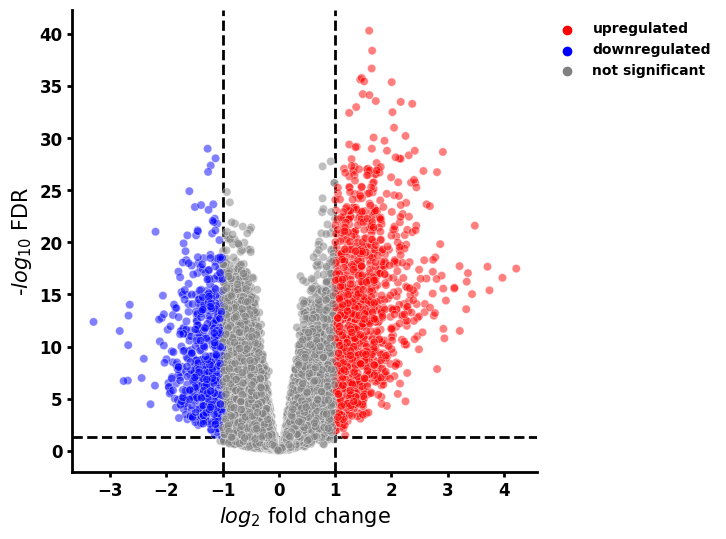

In [63]:
result = result.reset_index().rename({"genes":"gene_name"},axis=1)

Volcanoplot.volcano_plot(result,texto=[],path_save="./Results/DE_Functional_analysis/Volcano_plot.png")

**Now, we will conduct a functional analysis (GSEA) based on prior knowledge (gene sets) to study the effect of our condition on biological processes.**

First we need to create a expression matrix in the correct format

Now we need the gene sets, I will use the hallmarks collection signatures (downloaded from https://www.gsea-msigdb.org/gsea/downloads.jsp )

In [64]:
signatures_path = "./Data/DE_Functional_analysis/Hallmarks.gmt"

In [65]:
df_cluster.sort_values(by="Condition",inplace=True,ascending=False)
normcounts_df = normcounts_df[df_cluster.index]

In [66]:
# Create the cls
cls_file = Functional_analysis.generate_cls(df_cluster.Condition,cls_path=f"./Data/DE_Functional_analysis/GSEA.cls")


gs_res = gp.gsea(data=normcounts_df, 
                gene_sets = signatures_path,
                cls= cls_file, 
                permutation_type='gene_set',
                permutation_num=1000,# Just for speed, normaly 1000 
                outdir=None,  
                no_plot=True, 
                method='signal_to_noise',
                max_size= 50000,
                min_size=0,
                format='png', verbose=True)

# Extract the top significative results

result, df_result =  Functional_analysis.sig_finder(gs_res)

if df_result.shape[0]>0:
    # Generate an save the GSEA NES plot and save the report
    Functional_analysis.NES_plot(df_result, outdir="./Results/DE_Functional_analysis/", dataset="Hallmarks")
    df_result.to_csv("./Results/DE_Functional_analysis/GSEA_NES_PLOT_report.csv",index=False)

2024-01-15 17:04:05,978 [INFO] Parsing data files for GSEA.............................
2024-01-15 17:04:06,065 [INFO] 0000 gene_sets have been filtered out when max_size=50000 and min_size=0
2024-01-15 17:04:06,066 [INFO] 0050 gene_sets used for further statistical testing.....
2024-01-15 17:04:06,067 [INFO] Start to run GSEA...Might take a while..................


cls file succesfully created in ./Data/DE_Functional_analysis/GSEA.cls


2024-01-15 17:04:14,049 [INFO] Congratulations. GSEApy ran successfully.................

